In [2]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import gpxpy.geo
from datetime import datetime
import time
import seaborn as sns
import os
import math
import xgboost as xgb
import matplotlib
matplotlib.use('nbagg')
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cluster import MiniBatchKMeans, KMeans
import warnings
warnings.simplefilter('ignore')

In [3]:
from sklearn.svm import SVC
#HAD TO USE SVR - Support Vector Regression bc SVC doesn't support continuous values
from sklearn.svm import SVR
from sklearn import metrics

### Preprocessing

In [4]:
new_frame = dd.read_csv("new_frame.csv")
day_time = new_frame['tpep_pickup_datetime']

In [5]:
new_frame.columns
new_frame.total_amount.head()

0     8.8
1    19.3
2    34.3
3    17.3
4     8.8
Name: total_amount, dtype: float64

In [6]:
new_frame_cleaned = new_frame[(new_frame.trip_duration>1) & (new_frame.trip_duration<100)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<80)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.trip_distance>0) & (new_frame_cleaned.trip_distance<23)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.total_amount>0) & (new_frame_cleaned.total_amount<90.6)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.fare_amount>0) & (new_frame_cleaned.fare_amount<90.6)]
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.pickup_latitude >= 40.5774) & (new_frame_cleaned.pickup_latitude <= 40.9176)) & ((new_frame_cleaned.pickup_longitude >= -74.15) & (new_frame_cleaned.pickup_longitude <= -73.7004)))]
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.RatecodeID == 1)]
new_frame_cleaned = new_frame_cleaned.drop(['Unnamed: 0'], axis=1)
new_frame_cleaned = new_frame_cleaned.drop(['tpep_pickup_datetime'], axis=1)
#new_frame_cleaned = new_frame_cleaned.join(new_frame['tpep_pickup_datetime'])

In [7]:
#new_frame_cleaned.head()
new_frame_cleaned.columns

Index(['trip_distance', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'total_amount', 'fare_amount',
       'RatecodeID', 'trip_duration', 'pickup_time', 'speed'],
      dtype='object')

In [8]:
x = new_frame_cleaned.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
scaled_new_frame_cleaned = pd.DataFrame(x_scaled, columns = new_frame_cleaned.columns)

In [9]:
df_x = scaled_new_frame_cleaned.drop(['RatecodeID', 'total_amount', 'fare_amount'], axis=1)
df_y = scaled_new_frame_cleaned.fare_amount

print(df_x.shape)
print(df_y.shape)
df_x.head()


(986980, 8)
(986980,)


,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_time,speed
0,0.239878,0.317193,0.492017,0.523229,0.546041,0.179133,0.000000e+00,0.224920
1,0.323901,0.281863,0.423421,0.404818,0.624620,0.263661,0.000000e+00,0.209925
2,0.051807,0.318953,0.496670,0.347322,0.519003,0.111510,4.059980e-07,0.075867
3,0.260775,0.400750,0.634791,0.506929,0.847181,0.104337,8.119961e-07,0.404003
4,0.139312,0.270996,0.435041,0.338778,0.326317,0.103313,8.119961e-07,0.217987


In [10]:
scaled_new_frame_cleaned.head()

,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,total_amount,fare_amount,RatecodeID,trip_duration,pickup_time,speed
0,0.239878,0.317193,0.492017,0.523229,0.546041,0.195111,0.221477,0.0,0.179133,0.000000e+00,0.224920
1,0.323901,0.281863,0.423421,0.404818,0.624620,0.275450,0.315436,0.0,0.263661,0.000000e+00,0.209925
2,0.051807,0.318953,0.496670,0.347322,0.519003,0.080340,0.087248,0.0,0.111510,4.059980e-07,0.075867
3,0.260775,0.400750,0.634791,0.506929,0.847181,0.183634,0.208054,0.0,0.104337,8.119961e-07,0.404003
4,0.139312,0.270996,0.435041,0.338778,0.326317,0.109032,0.120805,0.0,0.103313,8.119961e-07,0.217987


In [11]:
df_y.head()

0    0.221477
1    0.315436
2    0.087248
3    0.208054
4    0.120805
Name: fare_amount, dtype: float64

In [12]:
df_y = df_y * 100
df_y.head()

0    22.147651
1    31.543624
2     8.724832
3    20.805369
4    12.080537
Name: fare_amount, dtype: float64

### Data Analysis

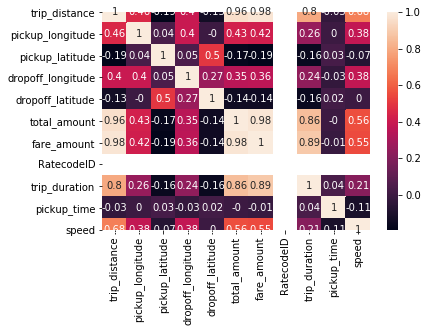

In [15]:
correlation_matrix = scaled_new_frame_cleaned.corr().round(2)
# annot = True to print the values inside the square
sns.heatmap(data=correlation_matrix, annot=True)

In [18]:
#Correlation between Manhattan distance of the ride and the taxi fare

def get_manhattan_dist(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return ((dropoff_long - pickup_long).abs() + (dropoff_lat - pickup_lat).abs())

# Add new column (manhattan_dist) to both training and test dataframe.

df_x['manhattan_dist'] = get_manhattan_dist(df_x.pickup_longitude, df_x.pickup_latitude,
                                              df_x.dropoff_longitude, df_x.dropoff_latitude).astype(np.float32)


#0.9, strong correlation between Manh distance and taxi fare
df_x.manhattan_dist.corr(df_y)


0.8665161245448104

In [19]:
def get_euclidean_dist(pickup_long, pickup_lat, dropoff_long, dropoff_lat):
    return np.sqrt(((pickup_long-dropoff_long)**2) + ((pickup_lat-dropoff_lat)**2))

df_x['euclidean_dist'] = get_euclidean_dist(df_x.pickup_longitude, df_x.pickup_latitude,
                                              df_x.dropoff_longitude, df_x.dropoff_latitude).astype(np.float32)


#0.92, strong correlation between Eucl distance and taxi fare
df_x.euclidean_dist.corr(df_y)

0.8855717177984859

Text(0, 0.5, 'Fare')

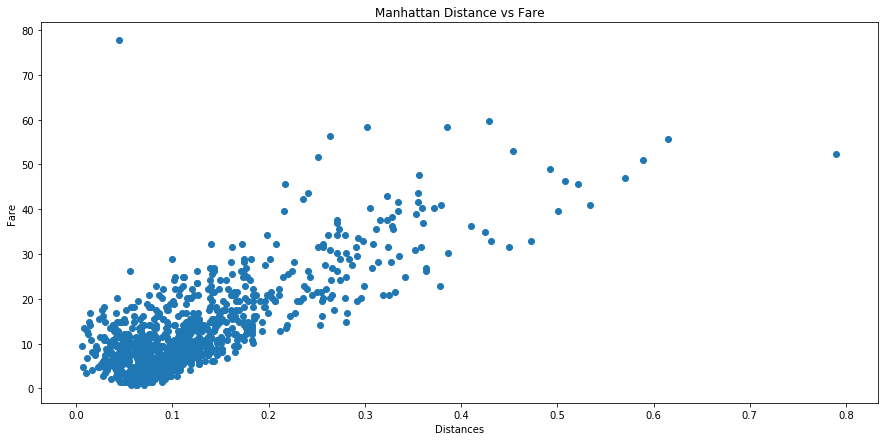

In [20]:
#Scattered plot between Manhattan distance of the ride and the taxi fare
plt.figure(figsize=(15,7))
plt.scatter(df_x.manhattan_dist[0:10**3],df_y[0:10**3])
plt.title('Manhattan Distance vs Fare')
plt.xlabel('Distances')
plt.ylabel('Fare')

Text(0, 0.5, 'Fare')

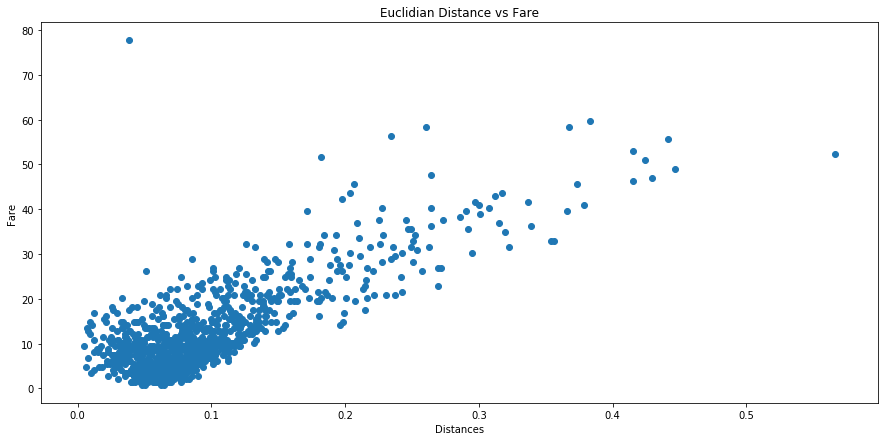

In [21]:
#Scattered plot between Euclidean distance of the ride and the taxi fare
plt.figure(figsize=(15,7))
plt.scatter(df_x.euclidean_dist[0:10**3],df_y[0:10**3])
plt.title('Euclidian Distance vs Fare')
plt.xlabel('Distances')
plt.ylabel('Fare')

In [22]:
#Converting the time of the day from Unix to YY/MM/DD format
time_of_day  = scaled_new_frame_cleaned["pickup_time"]
day_time = new_frame['tpep_pickup_datetime']
print(type(day_time ))
df = day_time.compute()
print(type(df ))

<class 'dask.dataframe.core.Series'>
<class 'pandas.core.series.Series'>


In [23]:
df = df.loc[~df.index.duplicated(keep='first')]
bigdata = pd.concat([df, df_x.euclidean_dist], axis=1)
bigdata.head()

,tpep_pickup_datetime,euclidean_dist
0,1/1/16 0:00,0.213001
1,1/1/16 0:00,0.235794
2,1/1/16 0:00,0.036105
3,1/1/16 0:00,0.237452
4,1/1/16 0:00,0.128123


In [24]:
#Converting the timestamp into hours, minutes, seconds
from datetime import datetime  
import datetime as dt  
bigdata.tpep_pickup_datetime = pd.to_datetime(bigdata.tpep_pickup_datetime, errors='coerce')
time_of_day = bigdata.tpep_pickup_datetime.dt.hour * 3600 + bigdata.tpep_pickup_datetime.dt.minute * 60 +  bigdata.tpep_pickup_datetime.dt.second
time_of_day.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: tpep_pickup_datetime, dtype: float64

In [25]:
#Correlation between time of day and distance traveled
#Weak correlation
time_of_day.corr(bigdata["euclidean_dist"])

-0.09849122586729443

In [26]:
#Correlation between time of day and the taxi fare
#Weak correlation
time_of_day.corr(df_y)

-0.09315834087231925

Text(0, 0.5, 'Distances')

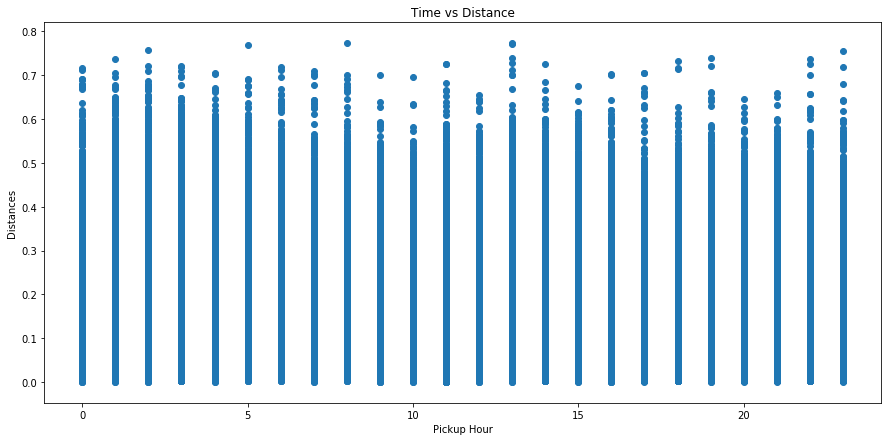

In [27]:
#Scattered plot between time of day and distance
plt.figure(figsize=(15,7))
plt.scatter(bigdata.tpep_pickup_datetime.dt.hour[0:10**6],bigdata["euclidean_dist"][0:10**6])
plt.title('Time vs Distance')
plt.xlabel('Pickup Hour')
plt.ylabel('Distances')

Text(0, 0.5, 'Fare')

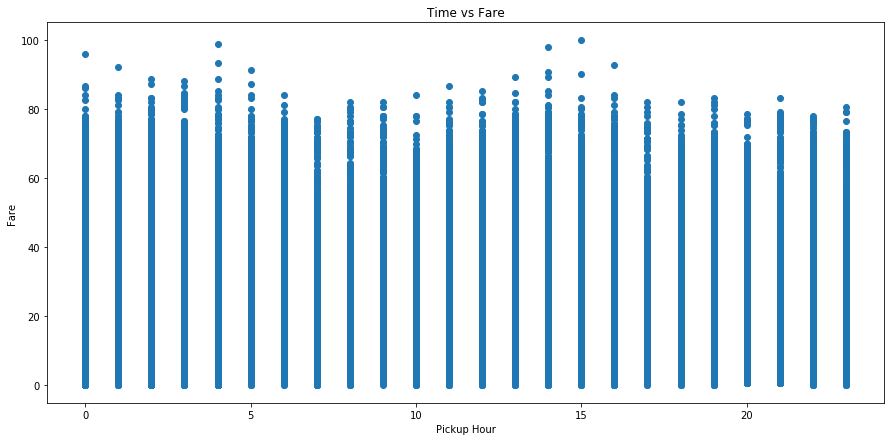

In [28]:
#Scattered plot between time of day and the taxi fare
plt.figure(figsize=(15,7))
plt.scatter(bigdata.tpep_pickup_datetime[0:10**6].dt.hour,df_y[0:10**6])
plt.title('Time vs Fare')
plt.xlabel('Pickup Hour')
plt.ylabel('Fare')

In [29]:
#correlation between trip duration and fare
df_x["trip_duration"].corr(df_y)

0.8944657808284321

Text(0, 0.5, 'Fare')

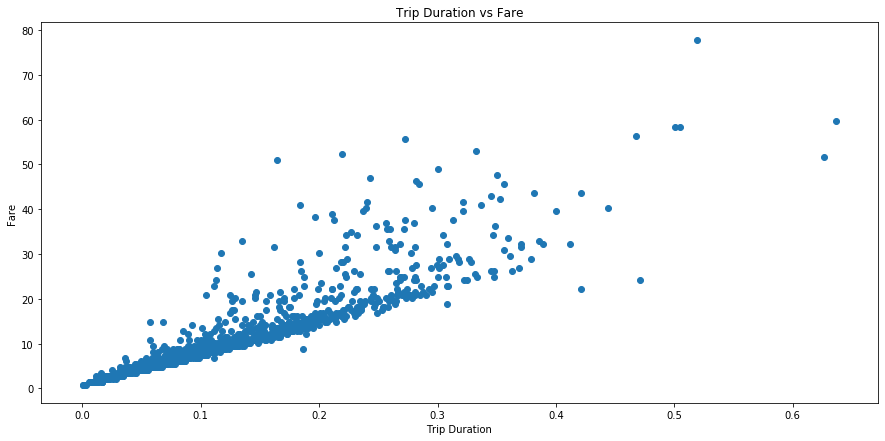

In [30]:
#Scattered plot between trip duration and taxi fare
plt.figure(figsize=(15,7))
plt.scatter(df_x["trip_duration"][0:10**3],df_y[0:10**3])
plt.title('Trip Duration vs Fare')
plt.xlabel('Trip Duration')
plt.ylabel('Fare')

In [128]:
#correlation between trip duration and time of the day (pickup time)
df_x["trip_duration"].corr(bigdata.tpep_pickup_datetime.dt.hour)

-0.09069386066334058

<IPython.core.display.Javascript object>


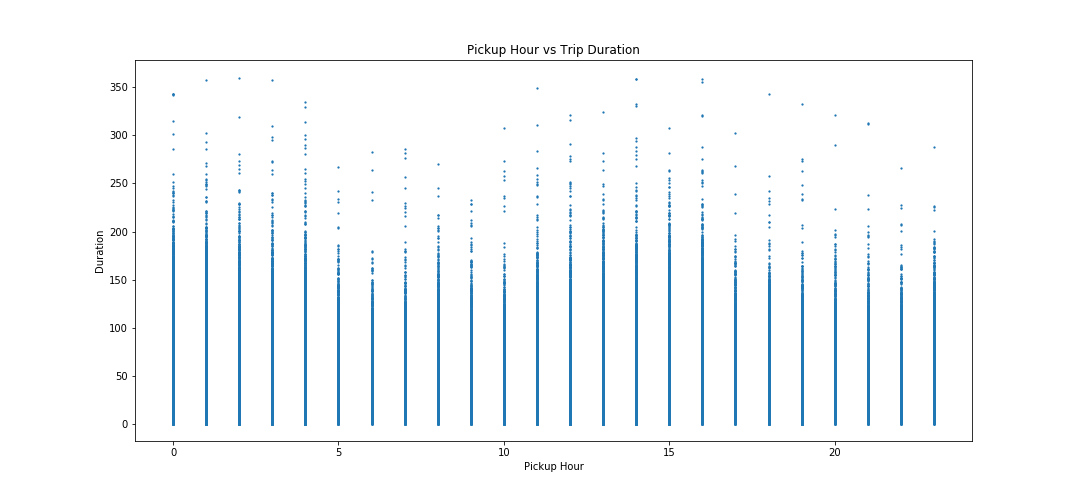

Text(0, 0.5, 'Duration')

In [130]:
#Scattered plot of time of the day vs trip duration
plt.figure(figsize=(15,7))
df_tripdist = df_x["trip_duration"] * 360
plt.scatter(x=bigdata.tpep_pickup_datetime[0:10**6].dt.hour, y=df_tripdist[0:10**6], s=1.5)
plt.title('Pickup Hour vs Trip Duration')
plt.xlabel('Pickup Hour')
plt.ylabel('Duration')

In [68]:
#correlation between speed vs fare
#not of much interest
df_x["speed"].corr(df_y)

0.5534876808611343

Text(0, 0.5, 'Number of Rides')

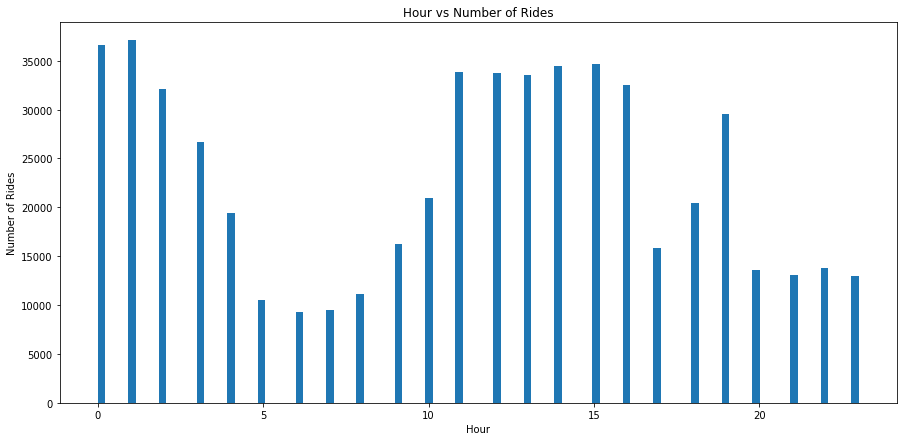

In [31]:
#Plot between Hour of day vs Number of Rides (during that time)
#pick hour is 1am
plt.figure(figsize=(15,7))
time_of_day_h = bigdata.tpep_pickup_datetime.dt.hour 
plt.hist(time_of_day_h, bins=100)
plt.title('Hour vs Number of Rides')
plt.xlabel('Hour')
plt.ylabel('Number of Rides')

<IPython.core.display.Javascript object>


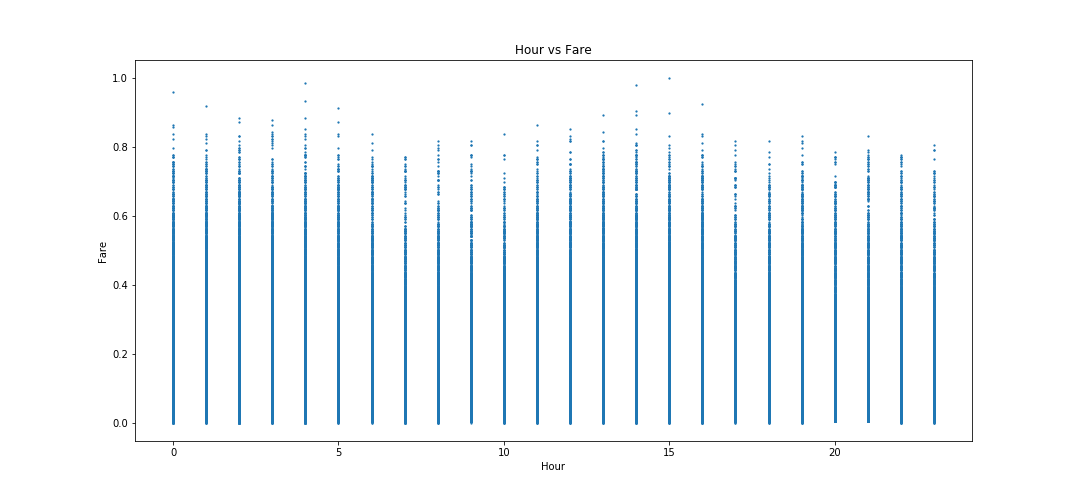

Text(0, 0.5, 'Fare')

In [39]:
#Scattered plot of pickup hours vs fare
#uniformly distributed
plt.figure(figsize=(15,7))
plt.scatter(x=bigdata.tpep_pickup_datetime[0:10**6].dt.hour, y=df_y[0:10**6], s=1.5)
plt.title('Hour vs Fare')
plt.xlabel('Hour')
plt.ylabel('Fare')

<IPython.core.display.Javascript object>


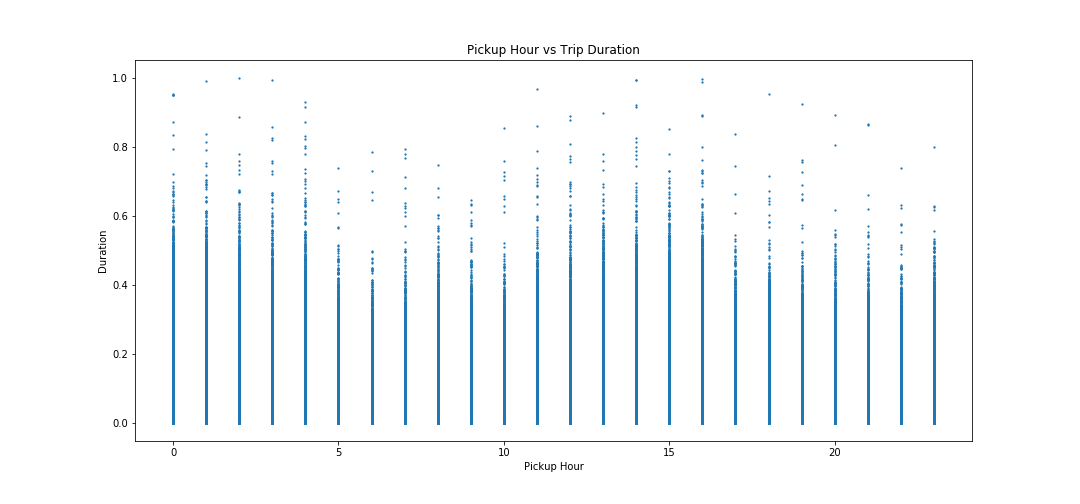

Text(0, 0.5, 'Duration')

In [71]:
#time of the day vs trip duration
plt.figure(figsize=(15,7))
plt.scatter(x=bigdata.tpep_pickup_datetime[0:10**6].dt.hour, y=df_x["trip_duration"][0:10**6], s=1.5)
plt.title('Pickup Hour vs Trip Duration')
plt.xlabel('Pickup Hour')
plt.ylabel('Duration')

### Clustering of locations with the most pickups

In [42]:
data_2016 = dd.read_csv("yellow_tripdata_2016-01.csv")

In [43]:
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
neighbors = []

def min_distance(regionCenters, totalClusters):
    good_points = 0
    bad_points = 0
    less_dist = []
    more_dist = []
    min_distance = 100000  #any big number can be given here
    for i in range(totalClusters):
        good_points = 0
        bad_points = 0
        for j in range(totalClusters):
            if j != i:
                distance = gpxpy.geo.haversine_distance(latitude_1 = regionCenters[i][0], longitude_1 = regionCenters[i][1], latitude_2 = regionCenters[j][0], longitude_2 = regionCenters[j][1])
                #you can check the documentation of above "gpxpy.geo.haversine_distance" at "https://github.com/tkrajina/gpxpy/blob/master/gpxpy/geo.py"
                #"gpxpy.geo.haversine_distance" gives distance between two latitudes and longitudes in meters. So, we have to convert it into miles.
                distance = distance/(1.60934*1000)   #distance from meters to miles
                min_distance = min(min_distance, distance) #it will return minimum of "min_distance, distance".
                if distance < 2:
                    good_points += 1
                else:
                    bad_points += 1
        less_dist.append(good_points)
        more_dist.append(bad_points)
    print("On choosing a cluster size of {}".format(totalClusters))
    print("Avg. Number clusters within vicinity where inter cluster distance < 2 miles is {}".format(np.ceil(sum(less_dist)/len(less_dist))))
    print("Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is {}".format(np.ceil(sum(more_dist)/len(more_dist))))
    print("Minimum distance between any two clusters = {}".format(min_distance))
    print("-"*10)
            
def makingRegions(noOfRegions):
    regions = MiniBatchKMeans(n_clusters = noOfRegions, batch_size = 10000).fit(coord)
    regionCenters = regions.cluster_centers_ 
    totalClusters = len(regionCenters)
    return regionCenters, totalClusters

In [44]:
def timeToUnix(t):
    #we have a time in the format "YYYY-MM-DD HH:MM:SS", which is a string
    change = datetime.strptime(t, "%Y-%m-%d %H:%M:%S") #this will convert the String time into datetime format
    t_tuple = change.timetuple() #this will convert the datetime formatted time into structured time
    return time.mktime(t_tuple) + 3600  #this will convert structured time into unix-time.
    #Now why, I have added 3600 in the above unix times. NOW, UNIX TIMESTAMP MEANS HOW MANY SECONDS HAVE ELAPSED SINCE 1 JAN 1970
    #(EPOCH) CALCULATED FROM THE REFERENCE OF GMT. I HAVE MADE THIS PROJECT IN GERMANY WHICH IS 1HR/3600SECS AHEAD OF GMT TIME, 
    #AND HERE "time.mktime()" FUNCTION RETURNS UNIX TIMESTAMP FROM THE REFERENCE OF LOCAL TIME. SO, THEREFORE, IN ORDER TO 
    #COMPENSATE FOR 1HR AHEAD, "time.mktime" SUBTRACTED 3600 SECONDS MEANS 1HR FROM UNIX TIME STAMP IN ORDER TO CATER TO 
    #LOCAL TIME. SO, THEREFORE, IF WE WANT OUR UNIX TIME TO BE EXACTLY EQUAL TO GMT TIME, WE HAVE TO ADD 3600 SECONDS 
    #MEANS 1HR TO UNIX TIME. lET SAY AT 12:00AM ON 1st JAN 1970, TIME ELAPSED AT GMT IS 0, THE TIME ELAPSED IN GERMANY IS 
    #3600SEC. NOW ON 1st JAN 2015, ELASPED SECONDS AT GMT IS 'X', SO THE EQUIVALENT ELAPSED SECONDS IN GERMANY WILL BE X+3600. 
    #NOW "time.mktime()" SUBTRACT THIS 3600 EXTRA IN GERMAN TIME WHICH WE HAVE TO ADD IN ORDER TO MAKE IT EQUAL TO GMT.

def dfWithTripTimes(df):
    startTime = datetime.now()
    duration = df[["tpep_pickup_datetime", "tpep_dropoff_datetime"]].compute()
    pickup_time = [timeToUnix(pkup) for pkup in duration["tpep_pickup_datetime"].values]
    dropoff_time = [timeToUnix(drpof) for drpof in duration["tpep_dropoff_datetime"].values]
#     trip_duration = []
#     for xy in zip(dropoff_time, pickup_time):
#         trip_duration.append(xy[0] - xy[1])
    trip_duration = (np.array(dropoff_time) - np.array(pickup_time))/float(60)  #trip duration in minutes
    
    NewFrame = df[['trip_distance','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude','total_amount', 'fare_amount', 'RatecodeID']].compute()
    NewFrame["trip_duration"] = trip_duration
    NewFrame["pickup_time"] = pickup_time
    NewFrame["speed"] = (NewFrame["trip_distance"]/NewFrame["trip_duration"])*60  #speed in miles/hr
    
    print("Time taken for creation of dataframe is {}".format(datetime.now() - startTime))
    return NewFrame

new_frame = dfWithTripTimes(data_2016)

Time taken for creation of dataframe is 0:12:31.874873


In [48]:
new_frame_cleaned = new_frame[(new_frame.trip_duration>1) & (new_frame.trip_duration<100)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.speed>0) & (new_frame_cleaned.speed<80)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.trip_distance>0) & (new_frame_cleaned.trip_distance<23)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.total_amount>0) & (new_frame_cleaned.total_amount<90.6)]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.fare_amount>0) & (new_frame_cleaned.fare_amount<90.6)]
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.pickup_latitude >= 40.5774) & (new_frame_cleaned.pickup_latitude <= 40.9176)) & ((new_frame_cleaned.pickup_longitude >= -74.15) & (new_frame_cleaned.pickup_longitude <= -73.7004)))]
new_frame_cleaned = new_frame_cleaned[(((new_frame_cleaned.dropoff_latitude >= 40.5774) & (new_frame_cleaned.dropoff_latitude <= 40.9176)) & ((new_frame_cleaned.dropoff_longitude >= -74.15) & (new_frame_cleaned.dropoff_longitude <= -73.7004)))]
new_frame_cleaned = new_frame_cleaned[(new_frame_cleaned.RatecodeID == 1)]

In [49]:
#running clustering to find the smallest distance between any two clusters that is less or equal to 0.5
startTime = datetime.now()
for i in range(10, 100, 10):
    regionCenters, totalClusters = makingRegions(i)
    min_distance(regionCenters, totalClusters)
print("Time taken = "+str(datetime.now() - startTime))

On choosing a cluster size of 10
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 2.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 8.0
Minimum distance between any two clusters = 1.24958703944144
----------
On choosing a cluster size of 20
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 3.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 16.0
Minimum distance between any two clusters = 0.6874450269232237
----------
On choosing a cluster size of 30
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 7.0
Avg. Number clusters outside of vicinity where inter cluster distance > 2 miles is 23.0
Minimum distance between any two clusters = 0.5141568750083315
----------
On choosing a cluster size of 40
Avg. Number clusters within vicinity where inter cluster distance < 2 miles is 8.0
Avg. Number clusters outside of vicinity where inter 

In [50]:
#cluster distance between any two clusters to be less than 0.5miles and when number of clusters are 40 then this condition is almost meeting
# sorting latitude and longitude in decreasing order
coord = new_frame_cleaned[["pickup_latitude", "pickup_longitude"]].values
print(coord)
regions = MiniBatchKMeans(n_clusters = 40, batch_size = 100000).fit(coord)

[[ 40.74304962 -73.9801178 ]
 [ 40.71998978 -73.9940567 ]
 [ 40.74461365 -73.97942352]
 ...
 [ 40.7507515  -74.00357819]
 [ 40.73485184 -74.00215912]
 [ 40.75101089 -74.00357819]]


In [52]:
new_frame_cleaned["pickup_cluster"] = regions.predict(new_frame_cleaned[["pickup_latitude", "pickup_longitude"]])

In [137]:
#map 1
centerOfRegions = regions.cluster_centers_
noOfClusters = len(centerOfRegions)
m = folium.Map(location = [40.9176, -73.7004], tiles = "Stamen Toner")

for i in range(noOfClusters):
    folium.Marker([centerOfRegions[i][0], centerOfRegions[i][1]], popup = (str(np.round(centerOfRegions[i][0], 2))+", "+str(np.round(centerOfRegions[i][1], 2)))).add_to(m)
m

<IPython.core.display.Javascript object>


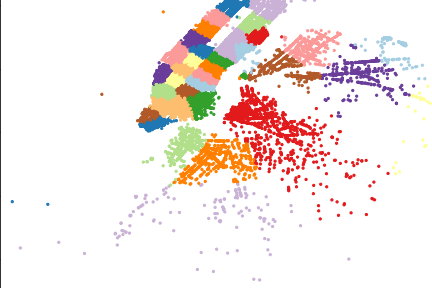

In [53]:
#map 2
NYC_latitude_range = (40.5774, 40.9176)
NYC_Longitude_range = (-74.15, -73.7004)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.scatter(x = new_frame_cleaned.pickup_longitude.values[:70000], y = new_frame_cleaned.pickup_latitude.values[:70000], c = new_frame_cleaned.pickup_cluster.values[:70000], cmap = "Paired", s = 5)
ax.set_xlim(-74.10, -73.72)
ax.set_ylim(40.5774, 40.9176)
ax.set_title("Regions in New York City")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


### Split Data

In [54]:
y = np.array(df_y)
x = np.array(df_x)

print(x.shape, y.shape)

(986980, 10) (986980,)


In [55]:
#k folds = 10
from sklearn.model_selection import KFold
x1 = preprocessing.scale(x)
y1 = np.array(y).reshape(-1,1)
kf = KFold(n_splits=10, shuffle=True)

scores = []
for train, test in kf.split(x1, y1):
    #train for k-1 folds
    X_train = x1[train]
    X_test = x1[test]
    Y_train = y1[train]
    Y_test = y1[test]

X_train = X_train[:100000]
X_test = X_test[:100000]
Y_train = Y_train[:100000]
Y_test = Y_test[:100000]

In [56]:
#train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=5)

In [57]:
x_train_1 = x_train[:100000]
y_train_1 = y_train[:100000]
print(x_train_1.shape)
print(y_train_1.shape)

(100000, 10)
(100000,)


### Support Vector Machine - SVR

#### Optimize with k-folds

#### Results: 
<li> RMSE: 0.05833117221423484 </li>
<li> R2: 0.5895835364886717 </li>
<li> MAE: 0.04921085567060481 </li>

In [58]:
#Support Vector Regression
#model 1, split data
clf_svm = SVR(gamma='scale', C=1.0, kernel='rbf')

In [59]:
clf_svm.fit(x_train_1, y_train_1)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [60]:
#prediction test
ypred_1 = clf_svm.predict(x_test)

#performance measurements
svr_rmse = np.sqrt(mean_squared_error(y_test, ypred_1))
svr_r2 = r2_score(y_test, ypred_1)
svr_mae = mean_absolute_error(y_test, ypred_1)
print(svr_rmse, svr_r2, svr_mae)

0.033038826450364434 0.902573539464523 0.027358431175732816


In [61]:
#model 1, k-fold
clf_svm = SVR(gamma='scale', C=1.0, kernel='rbf')
clf_svm.fit(X_train, Y_train)
#prediction test
ypred_1 = clf_svm.predict(X_test)

#performance measurements
svr_rmse = np.sqrt(mean_squared_error(Y_test, ypred_1))
svr_r2 = r2_score(Y_test, ypred_1)
svr_mae = mean_absolute_error(Y_test, ypred_1)
print(svr_rmse, svr_r2, svr_mae)

0.034394488858025415 0.8942069704128397 0.027694488473175054


In [62]:
#grid search svm
parameters = {'kernel':('linear', 'rbf'), 'C':[1000, 5000]}
clf = GridSearchCV(clf_svm, parameters, cv=5)
clf.fit(x_train_1, y_train_1)

KeyboardInterrupt: 

In [63]:
#model 3, model 4
clf_svr1 = SVR(C=1000, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.2, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False)

clf_svr2 = SVR(C = 5000, gamma = 0.001, kernel = 'rbf')

In [64]:
#fit model 3 and 4, split and kf
clf_svr1.fit(x_train_1, y_train_1)
clf_svr2.fit(x_train_1, y_train_1)
clf_svr1.fit(X_train, Y_train)
clf_svr2.fit(X_train, Y_train)

SVR(C=5000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [65]:
#model 3 and 4 predictions, split and kf
ypred_1_ts = clf_svr1.predict(x_test)
ypred_2_ts = clf_svr2.predict(x_test)
ypred_1_kf = clf_svr1.predict(X_test)
ypred_2_kf = clf_svr2.predict(X_test)

In [66]:
#model 3 and 4 performance measurements
svr_rmse1 = np.sqrt(mean_squared_error(y_test, ypred_1_ts))
svr_r21 = r2_score(y_test, ypred_1_ts)
svr_mae1 = mean_absolute_error(y_test, ypred_1_ts)
print(svr_rmse1, svr_r21, svr_mae1)

svr_rmse2 = np.sqrt(mean_squared_error(y_test, ypred_2_ts))
svr_r22 = r2_score(y_test, ypred_2_ts)
svr_mae2 = mean_absolute_error(y_test, ypred_2_ts)
print(svr_rmse2, svr_r22, svr_mae2)

svr_rmse3 = np.sqrt(mean_squared_error(Y_test, ypred_1_kf))
svr_r23 = r2_score(Y_test, ypred_1_kf)
svr_mae3 = mean_absolute_error(Y_test, ypred_1_kf)
print(svr_rmse3, svr_r23, svr_mae3)

svr_rmse4 = np.sqrt(mean_squared_error(Y_test, ypred_2_kf))
svr_r24 = r2_score(Y_test, ypred_2_kf)
svr_mae4 = mean_absolute_error(Y_test, ypred_2_kf)
print(svr_rmse4, svr_r24, svr_mae4)

0.13031439717481744 -0.5156973751325924 0.11806742683050259
0.11235035728540885 -0.12661781797078153 0.06749947047473295
0.11952380487329861 -0.27758014696957534 0.11543483887507909
0.06057061441132276 0.6719022192487907 0.05820300012381976


<IPython.core.display.Javascript object>


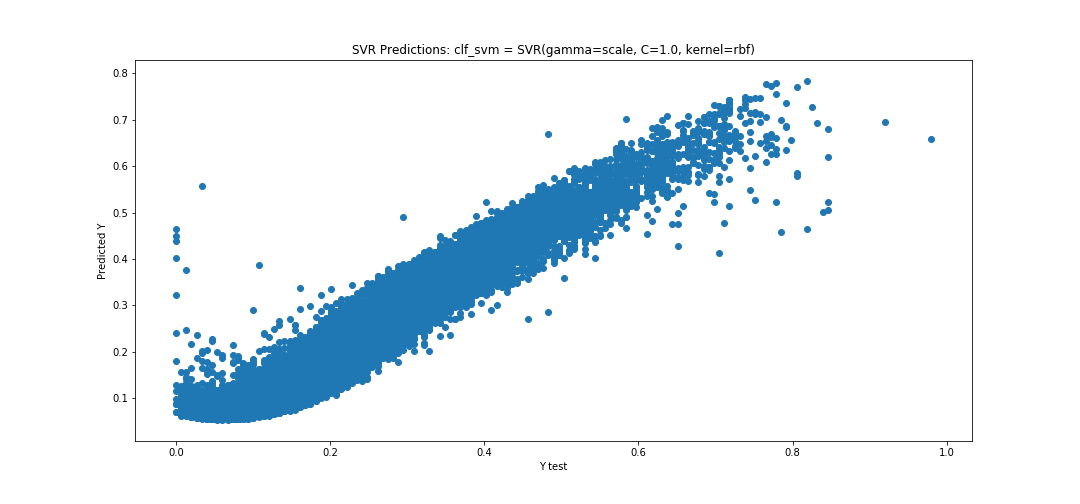

Text(0, 0.5, 'Predicted Y')

In [136]:
#Scattered plot between time of day and the taxi fare
plt.figure(figsize=(15,7))
plt.scatter(Y_test[0:10**6],ypred_1[0:10**6])
plt.title('SVR Predictions: clf_svm = SVR(gamma=scale, C=1.0, kernel=rbf)')
plt.xlabel('Y test')
plt.ylabel('Predicted Y')